# WHT ISIS Long-slit Spectroscopy Reduction

The following reduction code works directly from the full set of images in a given nights observations. As observations are added during the evening, the ImageFileCollection object defined at the beginning needs to be refreshed.

Files can be rsync'd from the whtobs computer using the following command:

`$ rsync -av whtobs@taurus.ing.iac.es:/obsdata/whta/20170624/ 20170624/`

where 20170624/ is set to the relevant observation night.

The starting point for this code was the very helpful scripts of [Steve Crawford](https://github.com/crawfordsm/wht_reduction_scripts). However, various changes have been made and key steps (e.g. wavelength calibration/flat processing) differ.


## Still to-do
- Add gain and readout noise values data frames
- Add uncertainty arrays for bias/flat frames etc.
- Complete wavelength calibration scripts
    - Write function to find wavelength solution for an input CuNe+CuAr arc frame
    - Apply wavelength solution to reduced target frames
- Propagate uncertainties to create variance map

- Flux calibration

In [199]:
import numpy as np
from multiprocessing import Pool
from functools import partial

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip, mad_std
from scipy.ndimage import binary_dilation
from astropy.utils.console import ProgressBar
import ccdproc
from ccdproc import ImageFileCollection, CCDData

def fit_chebyshev(row, degree=5, grow=3):
    """
    Fit Chebyshev1D model to a CCD row, including masking of outlier pixels
    
    Params
    ------
    row : array,
        Input CCD row to fit polynomial to.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    """

    fitter = fitting.LinearLSQFitter()
    input_mask = row.mask
    clipped = sigma_clip(row, stdfunc=mad_std)
    clipped_pixels = np.array(clipped.mask+row.mask).astype('float')
    clipped_pixels = binary_dilation(clipped_pixels, iterations=grow)

    row[clipped_pixels==1] = np.median(row)
    masked_row = np.ma.array(data=row, 
                             mask=(clipped_pixels == 1), 
                             fill_value=np.median(row))
    x = np.arange(len(row))
    model = models.Chebyshev1D(degree=degree)
    fitted_model = fitter(model, x, row)
    return fitted_model(np.arange(len(row)))

def fit_background_old(data, degree=5, grow=3, verbose=True):
    """
    Background estimation for longslit CCD image
    
    Params
    ------
    ccd : array,
        Input CCD data for background estimation.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    verbose : bool, default=True
        If true, print progress bar
        
    """
    fitted_sky = np.zeros_like(data).astype('float')
    if verbose:
        bar = ProgressBar(data.shape[0], ipython_widget=True)
    
    for irx, row in enumerate(data):
        fitted_sky[irx] = fit_chebyshev(row, degree, grow)
        if verbose:
            bar.update()
    return fitted_sky

def fit_background(data, degree=5, grow=3, verbose=True, njobs=4):
    """
    Parallelised background estimation for longslit CCD image
    
    Params
    ------
    data : array,
        Input CCD data for background estimation.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    njobs : int
        Number of processes to initiate for fitting
    """
    kwargs={'degree': degree, 'grow': grow}    
    p = Pool(njobs)
    fitted_sky = p.map(partial(fit_chebyshev, **kwargs), data)
    p.close()
    return np.array(fitted_sky).astype('float')

In [200]:
ic1 = ImageFileCollection('../20170626/')

## Create the bias frames



In [201]:
blue_bias_list = []
for filename in ic1.files_filtered(obstype='Bias', isiarm='Blue arm'):
    print ic1.location + filename
    ccd = CCDData.read(ic1.location + filename, unit = u.adu)
    #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
    #                               readnoise=ccd.header['READNOIS']*u.electron)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'])
    blue_bias_list.append(ccd)
    
master_bias_blue = ccdproc.combine(blue_bias_list, method='median')
master_bias_blue.write('../20170626/processed/master_bias_blue.fits', clobber=True)

red_bias_list = []
for filename in ic1.files_filtered(obstype='Bias', isiarm='Red arm'):
    print ic1.location + filename
    ccd = CCDData.read(ic1.location + filename, unit = u.adu)
    #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
    #                               readnoise=ccd.header['READNOIS']*u.electron)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    red_bias_list.append(ccd)
    
master_bias_red = ccdproc.combine(red_bias_list, method='median')
master_bias_red.write('../20170626/processed/master_bias_red.fits', clobber=True)

INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545087.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545089.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


../20170626/r2545091.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545093.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545095.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545097.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545099.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545101.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545103.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


../20170626/r2545105.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545086.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545088.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545090.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545092.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545094.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545096.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


../20170626/r2545098.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
../20170626/r2545100.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


../20170626/r2545102.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


../20170626/r2545104.fit
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


## Create the flat fields

In [203]:
from astropy.convolution import convolve, Gaussian2DKernel
kernel = Gaussian2DKernel(25)

red_flat_list = []
for filename in ic1.files_filtered(obstype='Flat', isiarm='Red arm', object='good flat red'):
    ccd = CCDData.read(ic1.location + filename, unit = u.adu)
    #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
    #                               readnoise=ccd.header['READNOIS']*u.electron)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias_red)    
    red_flat_list.append(ccd)
    
master_flat_red = ccdproc.combine(red_flat_list, method='median')
convolved_flat_red = convolve(master_flat_red.data, kernel, boundary='extend')

master_flat_red.write('../20170626/processed/master_flat_red.fits', clobber=True)

master_flat_red.data /= convolved_flat_red
master_flat_red.write('../20170626/processed/master_flat_norm_red.fits', clobber=True)

INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]


In [204]:
blue_flat_list = []
for filename in ic1.files_filtered(obstype='Flat', isiarm='Blue arm', object='good flat blue'):
    ccd = CCDData.read(ic1.location + filename, unit = u.adu)
    #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
    #                               readnoise=ccd.header['READNOIS']*u.electron)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias_blue)
    blue_flat_list.append(ccd)
    
master_flat_blue = ccdproc.combine(blue_flat_list, method='median')
convolved_flat_blue = convolve(master_flat_blue.data, kernel, boundary='extend')

master_flat_blue.write('../20170626/master_flat_blue.fits', clobber=True)

master_flat_blue.data /= convolved_flat_blue
master_flat_blue.write('../20170626/processed/master_flat_norm_blue.fits', clobber=True)

INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [ccdproc.ccddata]


## Reduce the object frames

In [285]:
ic1 = ImageFileCollection('../20170626/')

objects = ['USS7'] #'SP1234+254', 'USS439'] 'USS268'

for objname in objects:
    print(objname)
    """
    Blue Arm
    """
    blue_target_list = []
    for ifx, filename in enumerate(ic1.files_filtered(obstype='TARGET', isiarm='Blue arm', object=objname)):
        print('{0} {1}'.format(ifx+1, filename))
        hdu = fits.open(ic1.location + filename)
        ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
        #this has to be fixed as the bias section does not include the whole section that will be trimmed
        ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
        ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
        ccd = ccdproc.subtract_bias(ccd, master_bias_blue)
        ccd = ccdproc.flat_correct(ccd, master_flat_blue)
        ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, niter=10, sigfrac=0.05, psffwhm=2.5, 
                                         gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])
        
        # Do sky subtraction
        ccd.mask[:,785:800] = True
        sky = fit_background(np.ma.array(ccd.data, mask=ccd.mask))
        ccd.data -= sky
        
        # Rotate Frame
        ccd.data = ccd.data.T
        ccd.mask = ccd.mask.T
        blue_target_list.append(ccd)
        #ccd.write('obj_'+filename, clobber=True)

    blue_target = ccdproc.combine(blue_target_list, method='average')
    blue_target.write('../20170626/processed/{0}_blue.fits'.format(blue_target_list[0].header['object']), clobber=True)

USS7
1 r2544944.fit


/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/anaconda/lib/python2.7/site-packa

2 r2544946.fit


/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked

3 r2545161.fit


/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/anaconda/lib/python2.7/site-packa

In [ ]:
ic1 = ImageFileCollection('../20170626/')

for objname in objects:
    print(objname)
    """
    Red Arm
    """
    red_target_list = []
    for ifx, filename in enumerate(ic1.files_filtered(obstype='TARGET', isiarm='Red arm', object=objname)):
        print('{0} {1}'.format(ifx+1, filename))
        hdu = fits.open(ic1.location + filename)
        ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
        #this has to be fixed as the bias section does not include the whole section that will be trimmed
        ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
        ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
        ccd = ccdproc.subtract_bias(ccd, master_bias_red)
        ccd = ccdproc.flat_correct(ccd, master_flat_red)
        ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, niter=10, sigfrac=0.05, psffwhm=2.5, 
                                         gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])
        
        # Do sky subtraction
        ccd.mask[:,690:700] = True
        sky = fit_background(np.ma.array(ccd.data, mask=ccd.mask))
        ccd.data -= sky
        
        # Rotate Frame
        
        ccd.data = ccd.data.T
        ccd.mask = ccd.mask.T
        #ccd.write('obj_'+filename, clobber=True)
        red_target_list.append(ccd)

    red_target = ccdproc.combine(red_target_list, method='average')
    red_target.write('{0}_red.fits'.format(red_target_list[0].header['object']), clobber=True)

    red_target.mask[785:800,:] = True
    red_sky = fit_background(np.ma.array(red_target.data.T, mask=red_target.mask.T)).T

    red_target.data -= red_sky
    red_target.write('../20170626/processed/{0}_red.fits'.format(red_target_list[0].header['object']), clobber=True)

USS7
1 r2544943.fit


(966, 4099)

## Reduce arc frames

In [38]:
for filename in ic1.files_filtered(obstype='Arc', isiarm='Blue arm', object='CuNe+CuAr b tar'):
    hdu = fits.open(ic1.location + filename)
    ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias_blue)
    ccd = ccdproc.flat_correct(ccd, master_flat_blue)
    ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])

    ccd.data = ccd.data.T
    ccd.mask = ccd.mask.T
    ccd.write('arc_blue_'+filename, clobber=True)
    
for filename in ic1.files_filtered(obstype='Arc', isiarm='Red arm', object='CuNe+CuAr r tar'):
    hdu = fits.open(ic1.location + filename)
    ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section='[1:966,4105:4190]')
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias_red)
    ccd = ccdproc.flat_correct(ccd, master_flat_red)
    
    ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])
    ccd.data = ccd.data.T
    ccd.mask = ccd.mask.T
    ccd.write('arc_red_'+filename, clobber=True)

<IPython.core.display.Javascript object>


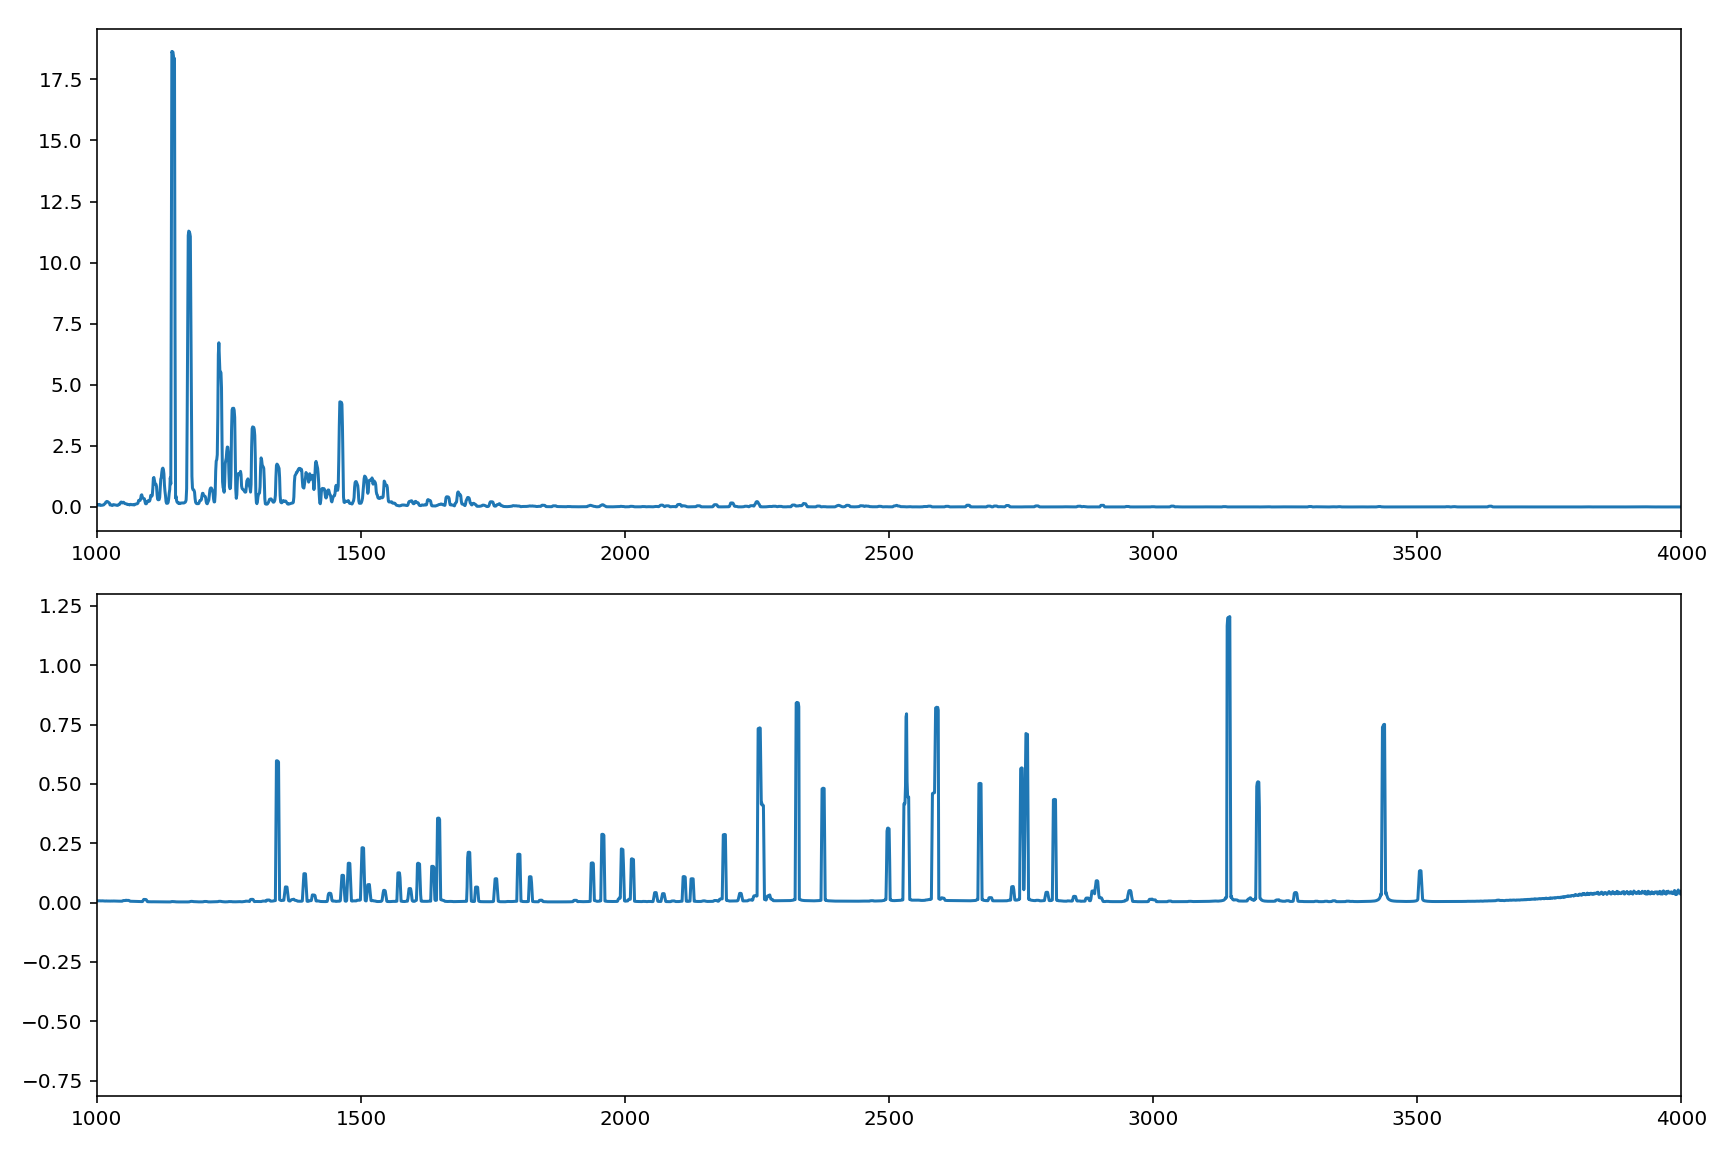

In [127]:
Fig, Ax = plt.subplots(2, 1, figsize=(12,8))

blue_arc_1d = np.median(CCDData.read('arc_blue_r2545050.fit').data/convolved_flat_blue.T, axis=0)
Ax[0].plot(np.arange(4099), blue_arc_1d)
Ax[0].set_xlim([1000,4000])
#Ax[0].set_ylim([0, 2000])

red_arc_1d = np.median(CCDData.read('arc_red_r2545051.fit').data/convolved_flat_red.T, axis=0)
Ax[1].plot(np.arange(4096), red_arc_1d)
Ax[1].set_xlim([1000,4000])
#Ax[1].set_ylim([0, 30000])
Fig.tight_layout()

blue_lines_pix = [1177, 1868, 1895, # 1846, 
                  2140, 2173, 2368, 2610, 
                  2703, 2950, 3000, 3132, 
                  3556, 3638]
blue_lines_w = [3273.96, 3868.53, 3891.98, #  3858.58, 
                4103.91, 4131.72, 4300.1, 4510.73, 
                4589.9, 4806.02, 4847.81, 4965.08, 
                5330.78, 5400.56]

red_lines_pix = [1341, 1392, 1938, 1994,
                 2057, 2072, 2111, 2188,
                 2498, 2672, 2814, 3143, 
                 3199, 3270, 3437, 3505]

red_lines_w = [5852.49, 5944.83, 6929.47, 7032.41, 
               7147.04, 7173.94, 7245.17, 7383.98,
               7948.17, 8264.52, 8521.44, 9122.97, 
               9224.5, 9354.22, 9657.78, 9784.5]

In [177]:
def line_models(mean_init):
    lmodels = []

    for ilx, line in enumerate(mean_init):
        compound_model = models.Gaussian1D(mean=mean_init[ilx], 
                                           amplitude=1., 
                                           stddev=1.,
                                           bounds = {'stddev':(0,5)})
        lmodels.append(compound_model)
    return lmodels

def fit_lines(spectra, mean_init):
    """ Fit emission lines for an observed WL target
    
    """
    lmodels = line_models(mean_init)

    fit = fitting.LevMarLSQFitter()
    fitted_models = []
    amplitudes = []
    means = []
    widths = []
    
    X = np.arange(len(spectra))
    #plt.plot(ccd_wavelengths.value, obs_flux[i])

    for model in lmodels:
        #dprint(wcenter)
        try:
            lower = int(np.maximum(0, model.mean-10))
            upper = int(np.minimum(len(spectra), model.mean+10))
            fitted_model = fit(model, X[lower:upper], spectra[lower:upper])
            fitted_models.append(fitted_model)
            amplitudes.append(fitted_model.amplitude.value)
            means.append(fitted_model.mean.value)
            widths.append(fitted_model.stddev.value)
            
            #plt.plot(ccd_wavelengths.value[lower:upper], fitted_model(ccd_wavelengths.value[lower:upper]))
            
        except:
            fitted_models.append(model)
            amplitudes.append(-99.)
            means.append(model.mean.value)
            widths.append(model.stddev.value)
            raise
    
    return means, widths, amplitudes, fitted_models

def evaluate_models(X, models):
    model_flux = np.zeros_like(X)
    for model in models:
        model_flux += model(X)
    return model_flux

def get_solution(spectrum, reference_lines_pix, reference_lines_lambda):
    
    means, widths, amplitudes, fmodels = fit_lines(spectrum, reference_lines_pix)
    
    fit = fitting.LinearLSQFitter()
    m = models.Legendre1D(degree=3)
    
    solution = fit(m, means, reference_lines_lambda)
    solution_lambda = solution(means)
    
    pixels = np.arange(len(spectrum))
    rms = np.sqrt(np.mean((solution_lambda-reference_lines_lambda)**2))
    
    return solution(pixels), rms, solution

def wavelength_calibration(image, reference_lines_pix, reference_lines_lambda, 
                           ref_file1, ref_file2):
    """
    Initial Solution
    """
    wavelengths = np.zeros(image.shape)
    rms = np.zeros(image.shape[0])
    for irx, row in enumerate(image):
        wavelengths[irx], rms[irx],  = get_solution(row, reference_lines_pix, reference_lines_lambda)
        
    """
    Second solution
    """
        
    
    return wavelengths, rms

In [197]:
test_red, rms_red = get_solution

0.98052345637890059

In [179]:
data = CCDData.read('arc_blue_r2545050.fit')
data.data = test
data.write('test_wavelength_solution.fits', overwrite=True)

<IPython.core.display.Javascript object>


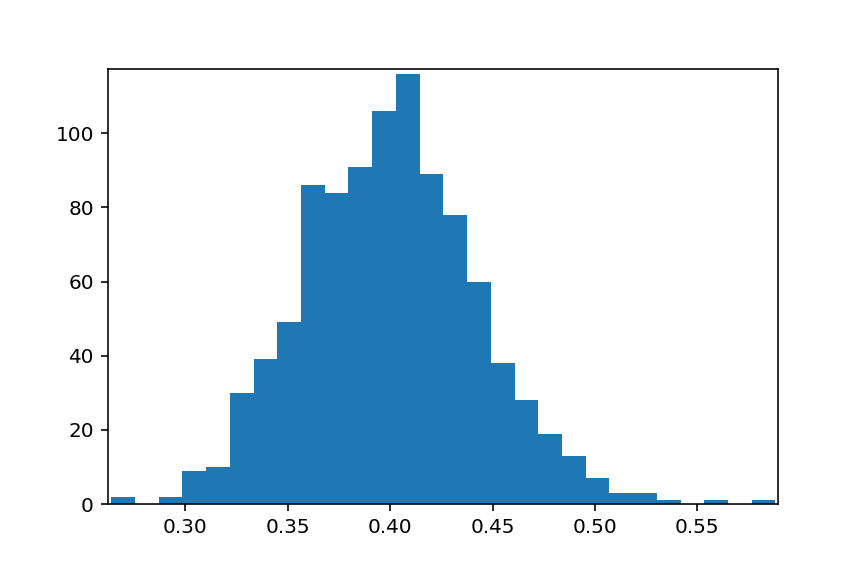

(array([   2.,    0.,    2.,    9.,   10.,   30.,   39.,   49.,   86.,
          84.,   91.,  106.,  116.,   89.,   78.,   60.,   38.,   28.,
          19.,   13.,    7.,    3.,    3.,    1.,    0.,    1.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

In [193]:
Fig, Ax = plt.subplots(1)
Ax.hist(rms, bins='auto')
#Ax.hist(test[:, 2500], bins='auto')

<IPython.core.display.Javascript object>


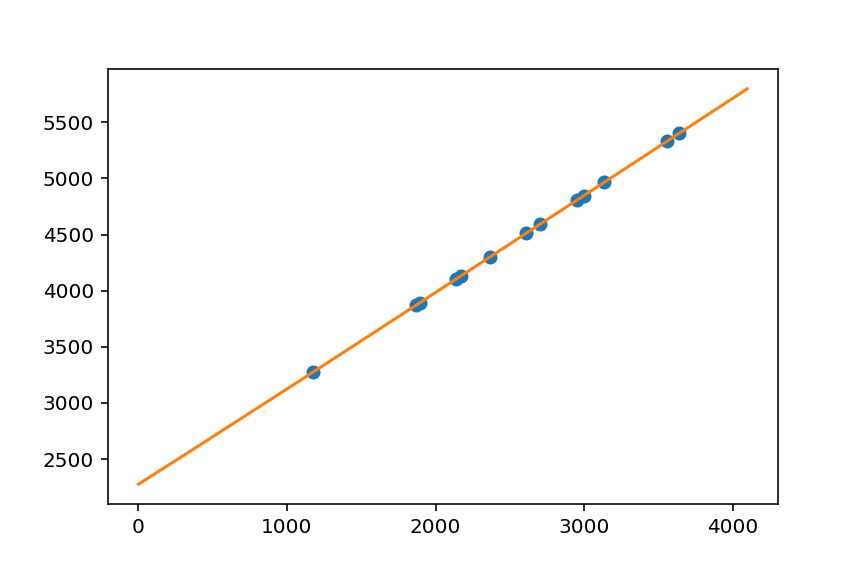

In [136]:
means, widths, amplitudes, fmodels = fit_lines(blue_arc_1d, blue_lines_pix)
X = np.arange(len(blue_arc_1d)).astype('float')
mf = evaluate_models(X, fmodels)

fit = fitting.LinearLSQFitter()
m = models.Legendre1D(degree=3)

fwave = fit(m, means, blue_lines_w)

%matplotlib notebook
plt.plot(means, blue_lines_w, 'o')
plt.plot(X, fwave(X))

<IPython.core.display.Javascript object>


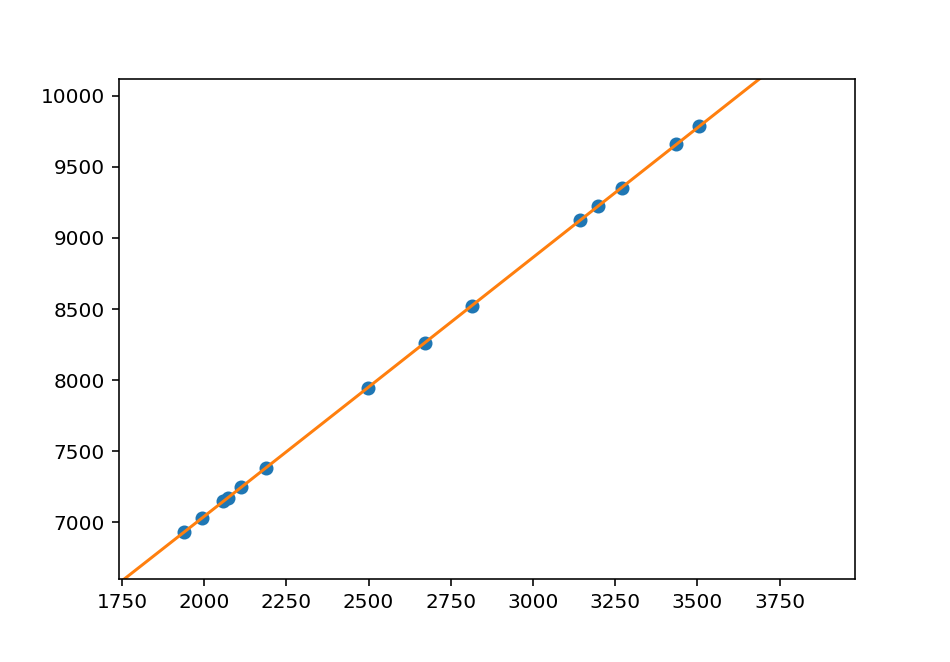

In [137]:
means, widths, amplitudes, fmodels = fit_lines(red_arc_1d, red_lines_pix)
X = np.arange(len(red_arc_1d)).astype('float')
mf = evaluate_models(X, fmodels)

fit = fitting.LinearLSQFitter()
m = models.Legendre1D(degree=3)

fwave = fit(m, means, red_lines_w)

%matplotlib notebook
plt.plot(means, red_lines_w, 'o')
plt.plot(X, fwave(X))

In [138]:
np.array(fwave(means)) - np.array(red_lines_w)

array([-0.2180614 ,  0.21211414,  0.2056568 ,  0.16496234, -0.27249106,
       -0.08936848,  0.30182848, -0.33373002, -0.30076815,  0.17621577,
        0.2816536 ,  0.13296402, -0.29599627, -0.02624645,  0.05572356,
        0.00554312])

In [113]:
fwave.slope

Parameter('slope', value=0.863296991521)

In [99]:
%matplotlib inline
np.array(means)-np.array(blue_lines_pix)

array([-1.95538274, -1.10752772, -1.30659563, -0.52980594, -1.25646576,
       -1.77915121, -1.69670061, -0.36518553, -1.56504222,  1.00254309,
       -0.74959237,  2.69278385,  1.0820998 , -0.02422022])

<IPython.core.display.Javascript object>


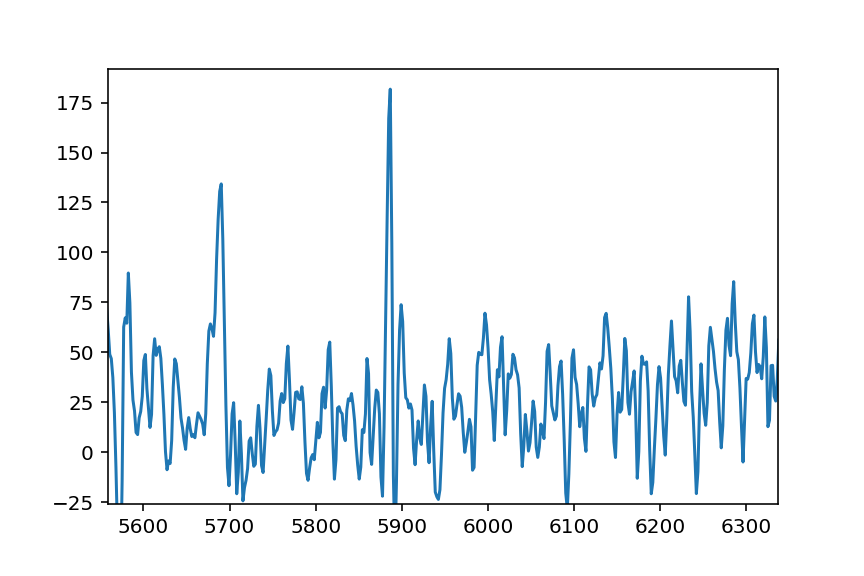

In [284]:
# Wavelength Solution
data_blue = CCDData.read('arc_blue_r2545050.fit')
test_blue, rms = get_solution(data_blue.data.sum(0), blue_lines_pix, blue_lines_w)

data_red = CCDData.read('arc_red_r2545051.fit')
test_red, rms = get_solution(data_red.data.sum(0), red_lines_pix, red_lines_w)


from astropy.convolution import Gaussian1DKernel
kernel = Gaussian1DKernel(stddev=1)
data_blue = CCDData.read('../20170626/processed/USS7_blue.fits')

uss439_blue_1d = data_blue.data[505:521,:].sum(axis=0)
blue_smoothed = convolve(uss439_blue_1d, kernel)
blue_smoothed_sky =  convolve(data_blue.data[505+30:521+30,:].sum(axis=0), kernel)


data_red = CCDData.read('../20170626/processed/USS7_red.fits')

uss439_red_1d = data_red.data[487:499,:].sum(axis=0)
red_smoothed = convolve(uss439_red_1d, kernel)
red_smoothed_sky =  convolve(data_red.data[487-30:499-30,:].sum(axis=0), kernel)

Fig, Ax = plt.subplots(1)
#Ax.plot(np.arange(len(blue_smoothed)), blue_smoothed-blue_smoothed_sky)
#Ax.plot(np.arange(len(red_smoothed)), red_smoothed-red_smoothed_sky)

#Ax.plot(test_blue, blue_smoothed-blue_smoothed_sky)
Ax.plot(test_red, red_smoothed-red_smoothed_sky)

In [26]:
kernel = Gaussian2DKernel(stddev=5)
uss202_blue = fits.open('USS202_blue.fits')
blue_smoothed = convolve(uss202_blue[0].data, kernel)

uss202_red = fits.open('USS202_red.fits')
red_smoothed = convolve(uss202_red[0].data, kernel)



<IPython.core.display.Javascript object>


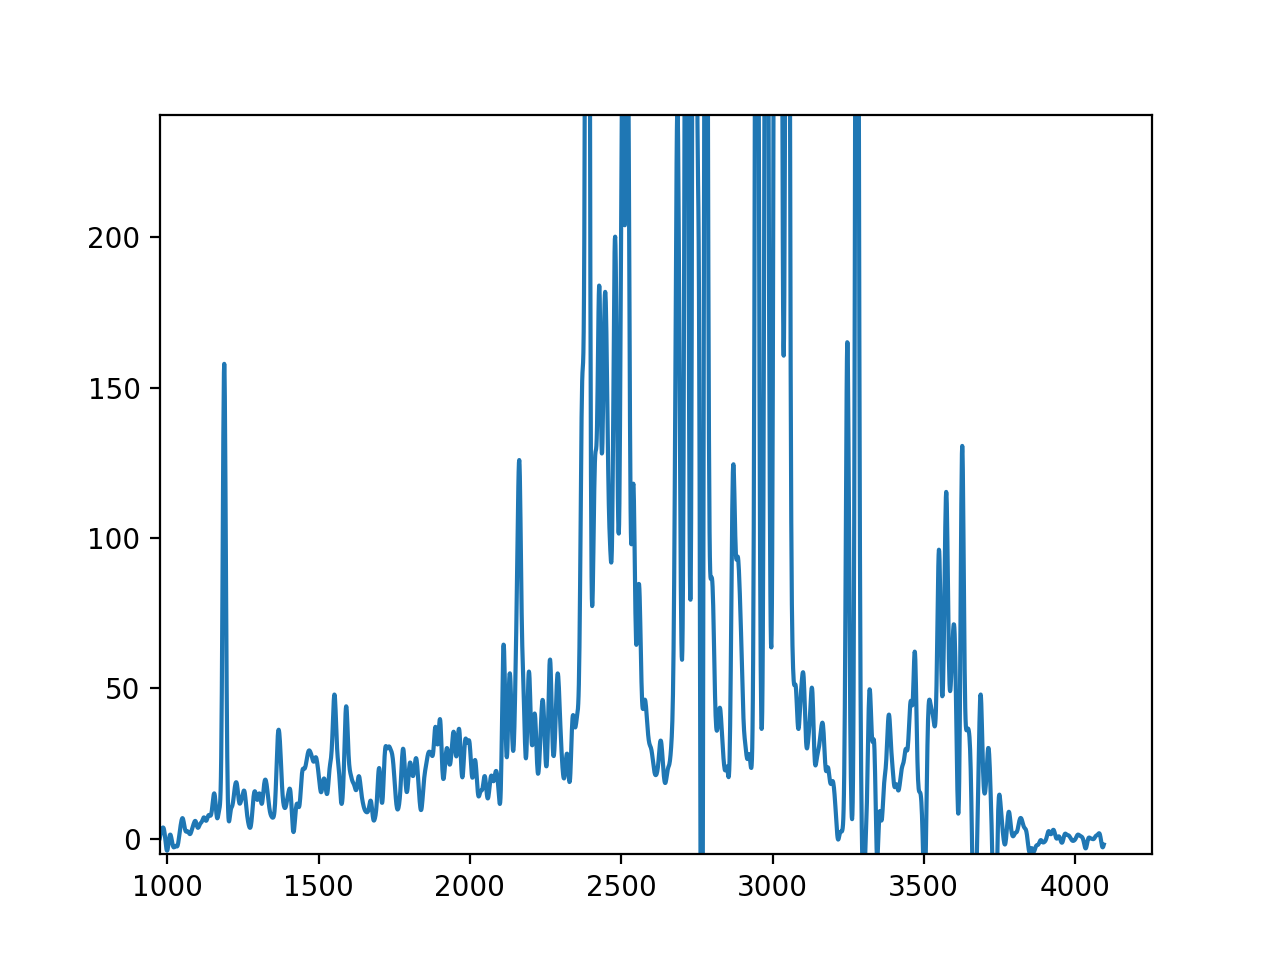

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
s1d = np.sum(red_smoothed[460:490,:], axis=0)
x = np.arange(len(s1d))
plt.plot(x, s1d)